In [1]:
import os
import sys
import pathlib
import pickle as pkl

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from datasets import deep_fashion
from arch import backbones, heads, models

from tqdm import tqdm

import utils.time

from time import time
from datetime import datetime

import pprint

In [2]:
experiment_name_str = "resnet50_ret_init_000"

results_dir = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", experiment_name_str)

In [3]:
def load_train_data(filename):

    train_data = None
    with open(filename, 'rb') as file:
        train_data = pkl.load(file)

    return train_data

---

In [4]:
train_data_filename = "experiment_data.pkl"
train_data_full_filename = os.path.join(results_dir, train_data_filename)

train_data = load_train_data(train_data_full_filename)

In [5]:
pprint.pprint(train_data["settings"])

{'backbone': {'class': 'ResNet50Backbone'},
 'data_loading': {'batch_size': 32, 'num_workers': 6},
 'datasets': ['DeepFashion Consumer-to-shop Clothes Retrieval Benchmark'],
 'gpu_usage': [{'device_id': 0,
                'device_name': 'NVIDIA GeForce GTX 1080 Ti',
                'device_size': 11811160064,
                'device_size_fancy': ' 11.000 GiB'}],
 'heads': [{'class': 'RetHead'}],
 'hostname': 'cudahpc07',
 'stage_1': {'description': 'Train with frozen backbone',
             'early_stopping': {'min_delta': 0, 'patience': 5},
             'extra': ['automatic_mixed_precision'],
             'learning_rate_list': [[0.00095],
                                    [0.0009025],
                                    [0.000857375],
                                    [0.0008145062499999999],
                                    [0.0007737809374999998],
                                    [0.0007350918906249997],
                                    [0.0006983372960937497],
         

In [6]:
pprint.pprint(train_data["results"])

{'stage_1': {'finished': True,
             'mean_train_loss_list': [0.2272624352593165,
                                      0.14269614529895303,
                                      0.11569228826969095,
                                      0.09926858298288728,
                                      0.08744255408116369,
                                      0.07832319893380749,
                                      0.0710373430484048,
                                      0.06503623510972184,
                                      0.06001937887767806,
                                      0.05570210422129428,
                                      0.05197557302061284,
                                      0.04870697067106969,
                                      0.04583145206426559,
                                      0.04328491255431108,
                                      0.04102052706228176],
             'mean_val_loss_list': [0.44307692611527794,
                            

---

In [7]:
mean_train_loss_list =\
    train_data["results"]["stage_1"]["mean_train_loss_list"] +\
    train_data["results"]["stage_2"]["mean_train_loss_list"]

mean_val_loss_list =\
    train_data["results"]["stage_1"]["mean_val_loss_list"] +\
    train_data["results"]["stage_2"]["mean_val_loss_list"]

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]

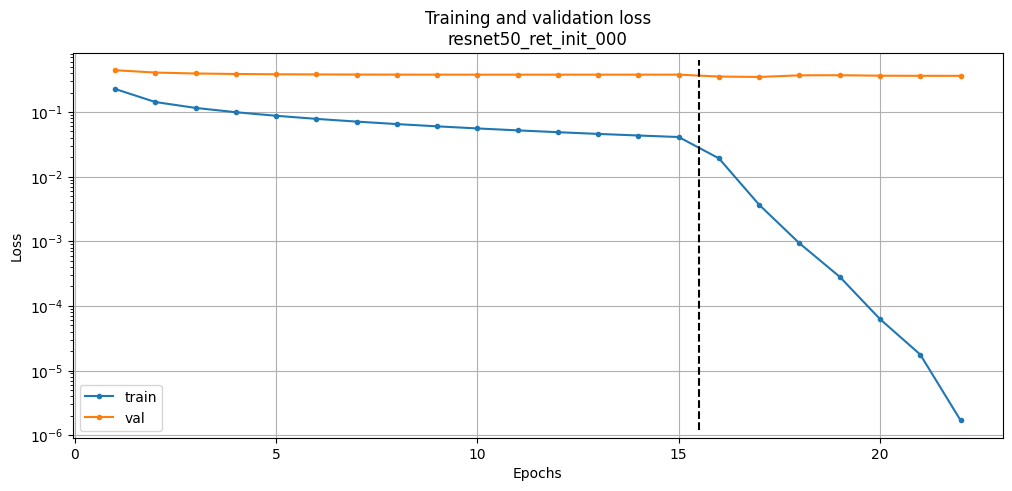

In [8]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train", marker=".")
plt.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val", marker=".")
plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

title = "Training and validation loss"
subtitle = "{:s}".format(experiment_name_str)

plt.title(title + "\n" + subtitle)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.grid()
plt.legend()

plt.show()

In [9]:
mean_train_loss_list =\
    train_data["settings"]["stage_1"]["learning_rate_list"] +\
    train_data["settings"]["stage_2"]["learning_rate_list"]

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]

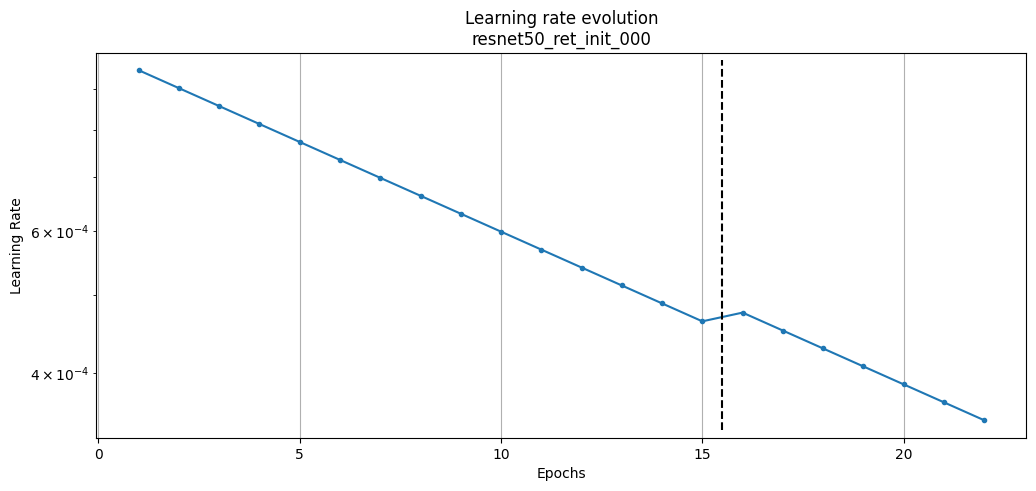

In [10]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, marker=".")
plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

title = "Learning rate evolution"
subtitle = "{:s}".format(experiment_name_str)

plt.title(title + "\n" + subtitle)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")

plt.grid()

plt.show()

In [11]:
train_epoch_time_list =\
    train_data["results"]["stage_1"]["train_epoch_time_list"] +\
    train_data["results"]["stage_2"]["train_epoch_time_list"]

val_epoch_time_list =\
    train_data["results"]["stage_1"]["val_epoch_time_list"] +\
    train_data["results"]["stage_2"]["val_epoch_time_list"]

total_epoch_time_list = np.asarray(train_epoch_time_list) + np.asarray(val_epoch_time_list)
total_epoch_time_list_acc = np.cumsum(total_epoch_time_list)

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]

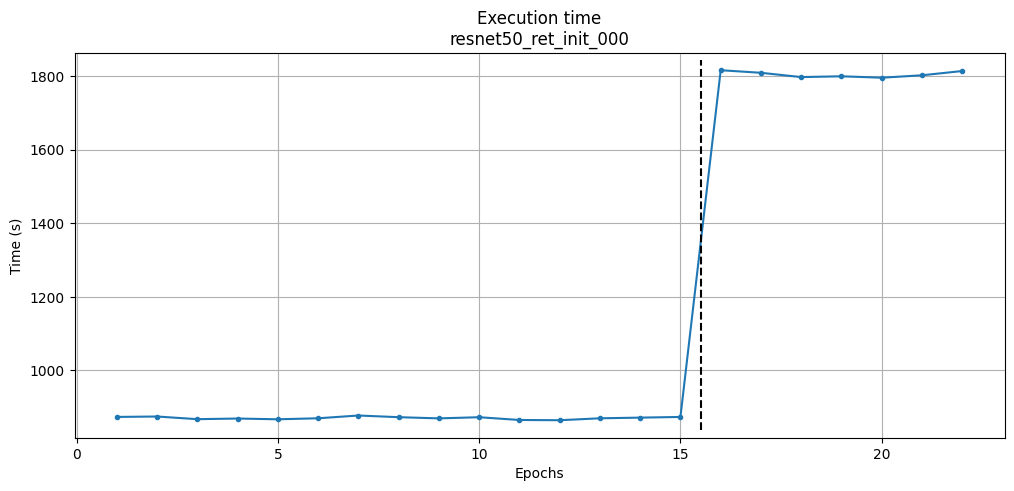

In [12]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(total_epoch_time_list) + 1), total_epoch_time_list, marker=".")
#plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

title = "Execution time"
subtitle = "{:s}".format(experiment_name_str)

plt.title(title + "\n" + subtitle)

plt.xlabel("Epochs")
plt.ylabel("Time (s)")

plt.grid()

plt.show()

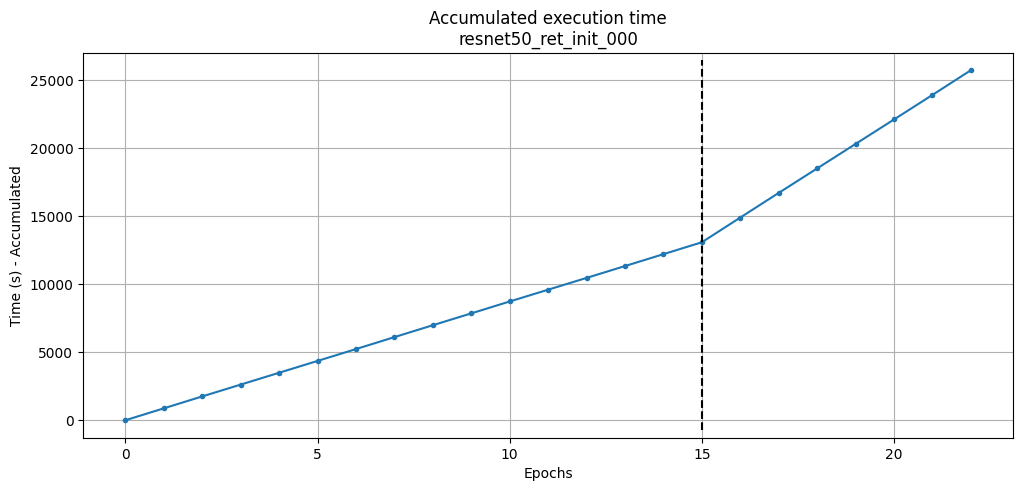

In [13]:
plt.figure(figsize=(12, 5))

plt.plot(range(len(total_epoch_time_list_acc) + 1), np.append(np.asarray([0]), total_epoch_time_list_acc), marker=".")
#plt.yscale("log")

plt.axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color="black", linestyle="--")

title = "Accumulated execution time"
subtitle = "{:s}".format(experiment_name_str)

plt.title(title + "\n" + subtitle)

plt.xlabel("Epochs")
plt.ylabel("Time (s) - Accumulated")

plt.grid()

plt.show()

In [14]:
total_stage_1_time =\
    sum(train_data["results"]["stage_1"]["train_epoch_time_list"]) +\
    sum(train_data["results"]["stage_1"]["val_epoch_time_list"])

total_stage_2_time =\
    sum(train_data["results"]["stage_2"]["train_epoch_time_list"]) +\
    sum(train_data["results"]["stage_2"]["val_epoch_time_list"])

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]
mean_stage_1_epoch_time = total_stage_1_time / stage_1_epochs

stage_2_epochs = train_data["results"]["stage_2"]["num_epochs"]
mean_stage_2_epoch_time = total_stage_2_time / stage_2_epochs

total_epoch_time = total_stage_1_time + total_stage_2_time

In [15]:
print("Total Stage 1 Time:      {:s}".format(utils.time.sprint_fancy_time_diff(total_stage_1_time)))
print("Total Stage 2 Time:      {:s}".format(utils.time.sprint_fancy_time_diff(total_stage_2_time)))
print("Mean Stage 1 Epoch Time: {:s}".format(utils.time.sprint_fancy_time_diff(mean_stage_1_epoch_time)))
print("Mean Stage 2 Epoch Time: {:s}".format(utils.time.sprint_fancy_time_diff(mean_stage_2_epoch_time)))
print("Total Epoch Time:        {:s}".format(utils.time.sprint_fancy_time_diff(total_epoch_time)))

Total Stage 1 Time:      3:37:43.607
Total Stage 2 Time:      3:30:29.286
Mean Stage 1 Epoch Time: 0:14:30.907
Mean Stage 2 Epoch Time: 0:30:04.183
Total Epoch Time:        7:08:12.894
